# Overview

This notebook demonstrates how to parse the FIA documents. We documents how to parse “Race Lap Analysis” in detail, and then move to all other docs later.

In [5]:
import re

import fitz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Some aesthetic settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
rc = {'figure.figsize': (4, 3),
      'axes.facecolor': 'white',             # Remove background colour
      'axes.grid' : False,                   # Turn on grid
      'axes.linewidth': '0.2',
      'axes.edgecolor': '0',                 # Set axes edge color to be black
      'font.size': 2,
      'xtick.major.size': 1,
      'xtick.major.width': 0.2,
      'ytick.major.size': 1,
      'ytick.major.width': 0.2}
plt.rcdefaults()
plt.rcParams.update(rc)


def show_image(item):
    """Display a pixmap

    :param item: Any PyMuPDF object having a "get_pixmap" method

    Just to display Pixmap image of "item" - ignore the man behind the curtain. Generates an RGB
    pixmap from item using a constant DPI and using matplotlib to show it inline of the notebook
    """
    DPI = 300
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))
    pass

# Race

## Rap Lap Analysis

The high-level steps to process a page are as follows:

1. get the page width $w$. The width is shared by three drivers, so driver $i$’s table is roughly positioned between $\frac{i}{3}w$ and $\frac{i + 1}{3}w$ of the page width. $i$ is 0-indexed
1. get the position ($x, y$) of "Race Lap Analysis". The table will be below this position, i.e. the table's top coordinate is $y$
1. find the word "Page", which appears at the bottom of the page. Let its coordinates be $(a, b)$. The tables are above "Page", so their bottom coordinates are $b$
1. given driver $i$ and his table $i$’s bounding box $(\frac{i}{3}w, y, \frac{i + 1}{3}w, b)$, extract the table
1. the driver's name is above the table's header. So get the position of the table extracted above, and call the top coordinate $h$. The driver's name is vertically bounded between $y$ and $h$, and horizontally still bounded between $\frac{i}{3}w$ and $\frac{i + 1}{3}w$

<center><img src="../1.svg" width="50%"></center>

In [88]:
# Page width
doc = fitz.open('../race_lap_analysis.pdf')
page = doc[0]
w = page.bound()[2]

# Position of "Race Lap Analysis"
y = page.search_for('Race Lap Analysis')[0].y1

# Position of "Page"
b = page.search_for('Page')[0].y0

Driver 2's number and name: ['3', 'Daniel RICCIARDO']
Driver 2's table 0's col.: ['LAP', '', 'TIME']
Driver 2's table 1's col.: ['LAP', '', 'TIME']


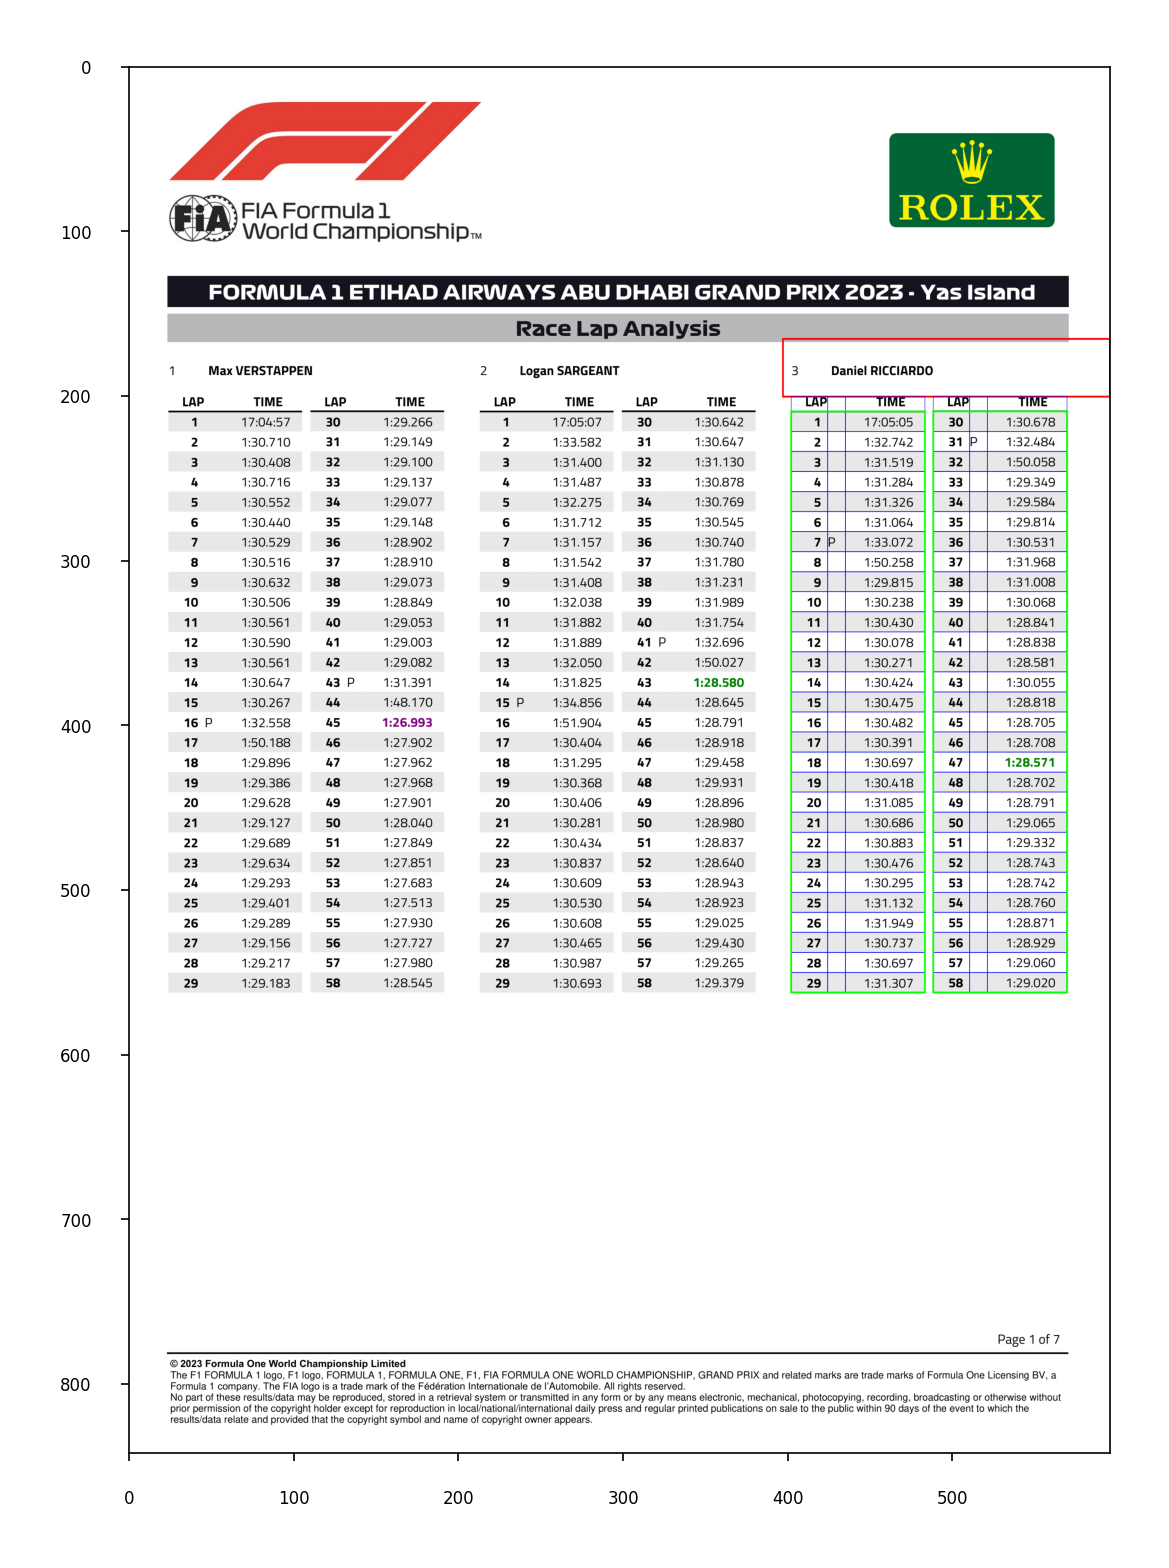

In [90]:
# Find the tables for the third driver (Ric) in page 1
page = doc[0]
for i in range(2, 3):

    # Find tables in the bounding box of driver i's table
    tabs = page.find_tables(clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, b), strategy='lines')

    # Find the position of a table' header
    h = tabs[0].header.bbox[1]

    # The driver's name is between `h` and `y`
    name = page.get_text('block', clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h)).strip()
    page.draw_rect(fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h), color=fitz.pdfcolor['red'])
    print((f"Driver {i}'s number and name: {name.split(maxsplit=1)}"))

    # Mark the tables for visualisation
    for j, tab in enumerate(tabs):  # iterate over all tables
        for cell in tab.header.cells:
            page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
        for cell in tab.cells:
            page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
        page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
        print(f"Driver {i}'s table {j}'s col.: {tab.header.names}")

show_image(page)

In [4]:
tabs[0].to_pandas().head()

LAP Col1      TIME
0   1       17:05:05
1   2       1:32.742
2   3       1:31.519
3   4       1:31.284
4   5       1:31.326

## Race Final Classification

### Race Final Classification

Go through all pages, and stop when we find "Race Final Classification". The table is on that page, positioned below "Race Final Classification" and above "FASTEST LAP". For some reasons, the automatic parsing can be wrong for certain columns (e.g. "NAT") or rows (e.g. first row with missing "GAP" and "INT" will have mis-positioned cells). This issue only involves "NO", "NAT", "TIME", "GAP", and "INT". We thus set all column positions manually.

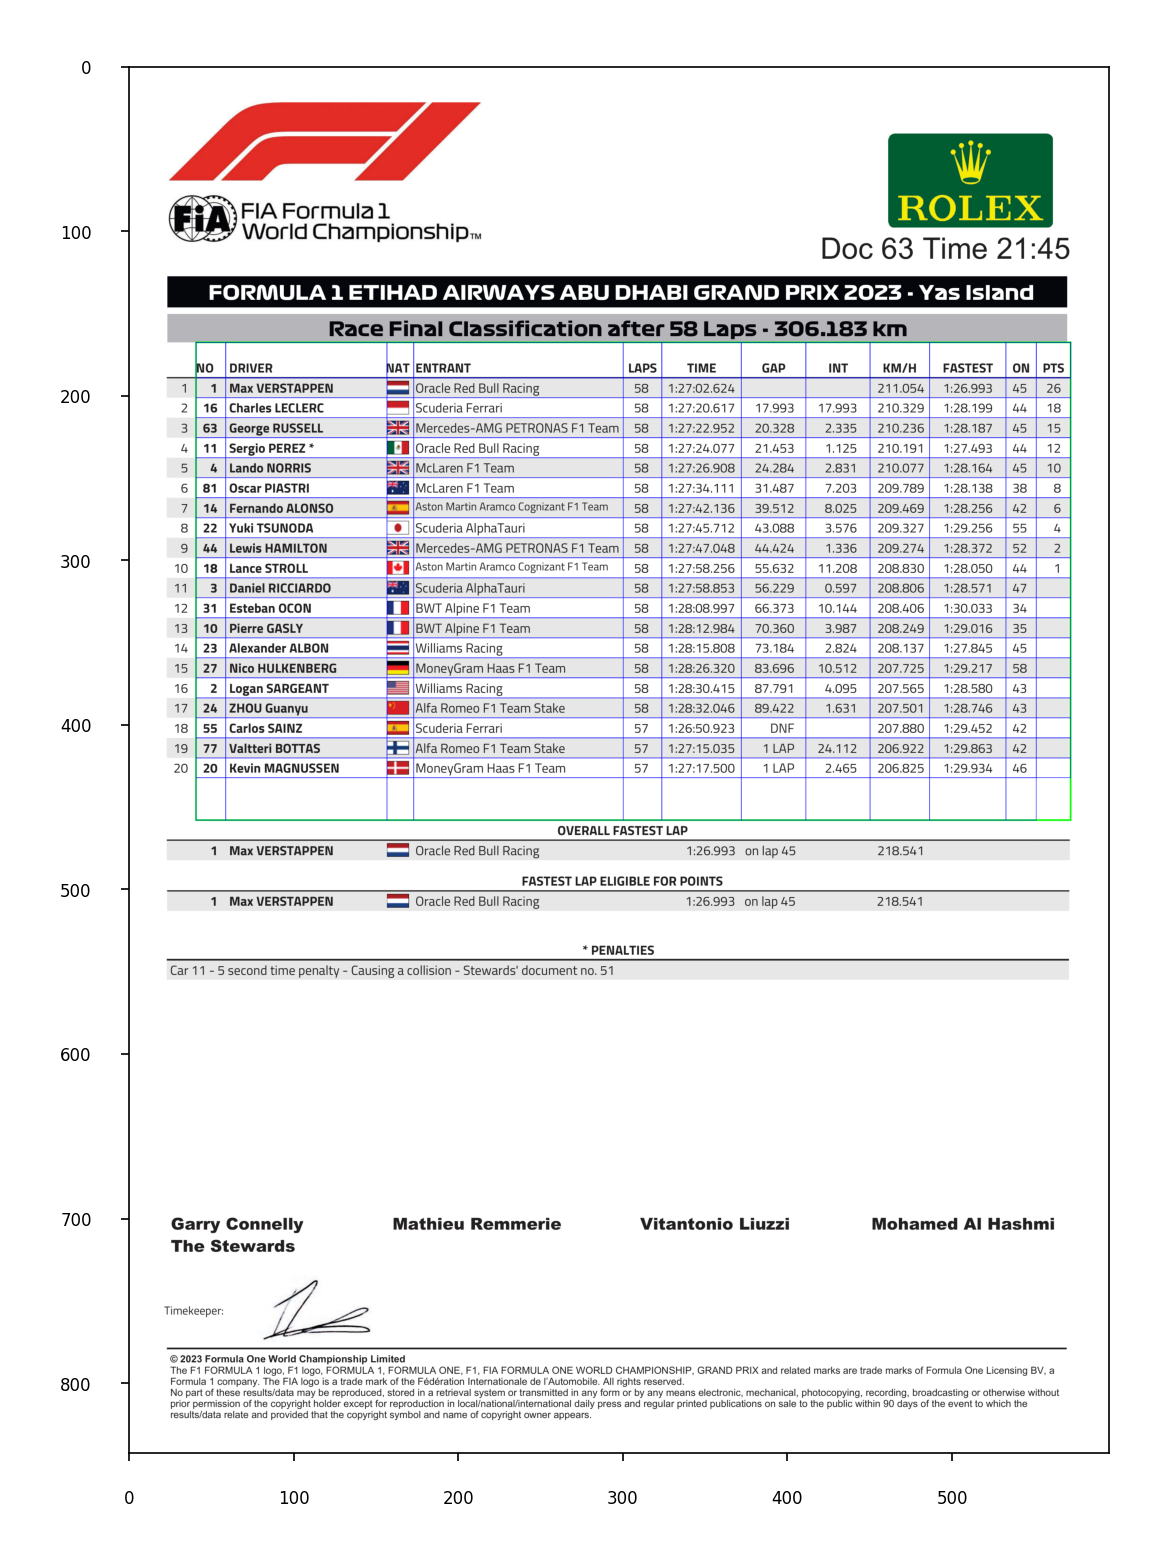

In [29]:
# Find the page with "Race Final Classification"
doc = fitz.open('../race_final_classification.pdf')
for i in range(len(doc)):
    page = doc[i]
    found = page.search_for('Race Final Classification')
    if found:
        break

# Width and height of the page
w, h = page.bound()[2], page.bound()[3]

# Position of "Race Final Classification"
y = found[0].y1

# Position of "FASTEST LAP"
b = page.search_for('FASTEST LAP')[0].y0

# Table bounding box
bbox = fitz.Rect(0, y, w, b)

# Positions of table headers/column names
pos = {}
for col in ['NO', 'DRIVER', 'NAT', 'ENTRANT', 'LAPS', 'TIME', 'GAP', 'INT', 'KM/H', 'FASTEST',
            'ON', 'PTS']:
    pos[col] = {
        'left': page.search_for(col, clip=bbox)[0].x0,
        'right': page.search_for(col, clip=bbox)[0].x1
    }

# Lines separating the columns
aux_lines = [
    pos['NO']['left'],
    (pos['NO']['right'] + pos['DRIVER']['left']) / 2,
    pos['NAT']['left'],
    pos['NAT']['right'],
    pos['LAPS']['left'],
    pos['LAPS']['right'],
    (pos['TIME']['right'] + pos['GAP']['left']) / 2,
    (pos['GAP']['right'] + pos['INT']['left']) / 2,
    (pos['INT']['right'] + pos['KM/H']['left']) / 2,
    pos['FASTEST']['left'],
    pos['FASTEST']['right'],
    pos['PTS']['left']
]


# Find the table below "Race Final Classification"
tabs = page.find_tables(
    clip=fitz.Rect(pos['NO']['left'], y, w, b),
    strategy='lines',
    vertical_lines=aux_lines,
    snap_x_tolerance=pos['ON']['left'] - pos['FASTEST']['right']
)
# Mark the tables for visualisation
for j, tab in enumerate(tabs):  # iterate over all tables
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)

show_image(page)

In [30]:
tab.to_pandas()

NO            DRIVER NAT                                ENTRANT LAPS  \
0    1    Max VERSTAPPEN                     Oracle Red Bull Racing   58   
1   16   Charles LECLERC                           Scuderia Ferrari   58   
2   63    George RUSSELL              Mercedes-AMG PETRONAS F1 Team   58   
3   11    Sergio PEREZ *                     Oracle Red Bull Racing   58   
4    4      Lando NORRIS                            McLaren F1 Team   58   
5   81     Oscar PIASTRI                            McLaren F1 Team   58   
6   14   Fernando ALONSO      Aston Martin Aramco Cognizant F1 Team   58   
7   22      Yuki TSUNODA                        Scuderia AlphaTauri   58   
8   44    Lewis HAMILTON              Mercedes-AMG PETRONAS F1 Team   58   
9   18      Lance STROLL      Aston Martin Aramco Cognizant F1 Team   58   
10   3  Daniel RICCIARDO                        Scuderia AlphaTauri   58   
11  31      Esteban OCON                         BWT Alpine F1 Team   58   
12  10      Pierre GASLY                         BWT Alpine F1 Team   58   
13  23   Alexander ALBON                            Williams Racing   58   
14  27   Nico HULKENBERG                     MoneyGram Haas F1 Team   58   
15   2    Logan SARGEANT                            Williams Racing   58   
16  24       ZHOU Guanyu                   Alfa Romeo F1 Team Stake   58   
17  55      Carlos SAINZ                           Scuderia Ferrari   57   
18  77   Valtteri BOTTAS                   Alfa Romeo F1 Team Stake   57   
19  20   Kevin MAGNUSSEN                     MoneyGram Haas F1 Team   57   
20                                                                         

           TIME     GAP     INT     KM/H   FASTEST  ON   PTS  
0   1:27:02.624                  211.054  1:26.993  45    26  
1   1:27:20.617  17.993  17.993  210.329  1:28.199  44    18  
2   1:27:22.952  20.328   2.335  210.236  1:28.187  45    15  
3   1:27:24.077  21.453   1.125  210.191  1:27.493  44    12  
4   1:27:26.908  24.284   2.831  210.077  1:28.164  45    10  
5   1:27:34.111  31.487   7.203  209.789  1:28.138  38     8  
6   1:27:42.136  39.512   8.025  209.469  1:28.256  42     6  
7   1:27:45.712  43.088   3.576  209.327  1:29.256  55     4  
8   1:27:47.048  44.424   1.336  209.274  1:28.372  52     2  
9   1:27:58.256  55.632  11.208  208.830  1:28.050  44     1  
10  1:27:58.853  56.229   0.597  208.806  1:28.571  47        
11  1:28:08.997  66.373  10.144  208.406  1:30.033  34        
12  1:28:12.984  70.360   3.987  208.249  1:29.016  35        
13  1:28:15.808  73.184   2.824  208.137  1:27.845  45        
14  1:28:26.320  83.696  10.512  207.725  1:29.217  58        
15  1:28:30.415  87.791   4.095  207.565  1:28.580  43        
16  1:28:32.046  89.422   1.631  207.501  1:28.746  43        
17  1:26:50.923     DNF          207.880  1:29.452  42        
18  1:27:15.035   1 LAP  24.112  206.922  1:29.863  42        
19  1:27:17.500   1 LAP   2.465  206.825  1:29.934  46        
20                                                      None

Have one empty row in the end, not a big problem; can drop it easily. Also drivers who received a penalty have an asterisk next to their name, which may need to be removed.

### OVERALL FASTEST LAP

Find the text "OVERALL FASTEST LAP" and "FASTEST LAP ELIGIBLE FOR POINTS". The fastest lap is between the top.

1
Max VERSTAPPEN
Oracle Red Bull Racing
1:26.993 on lap 45
218.541


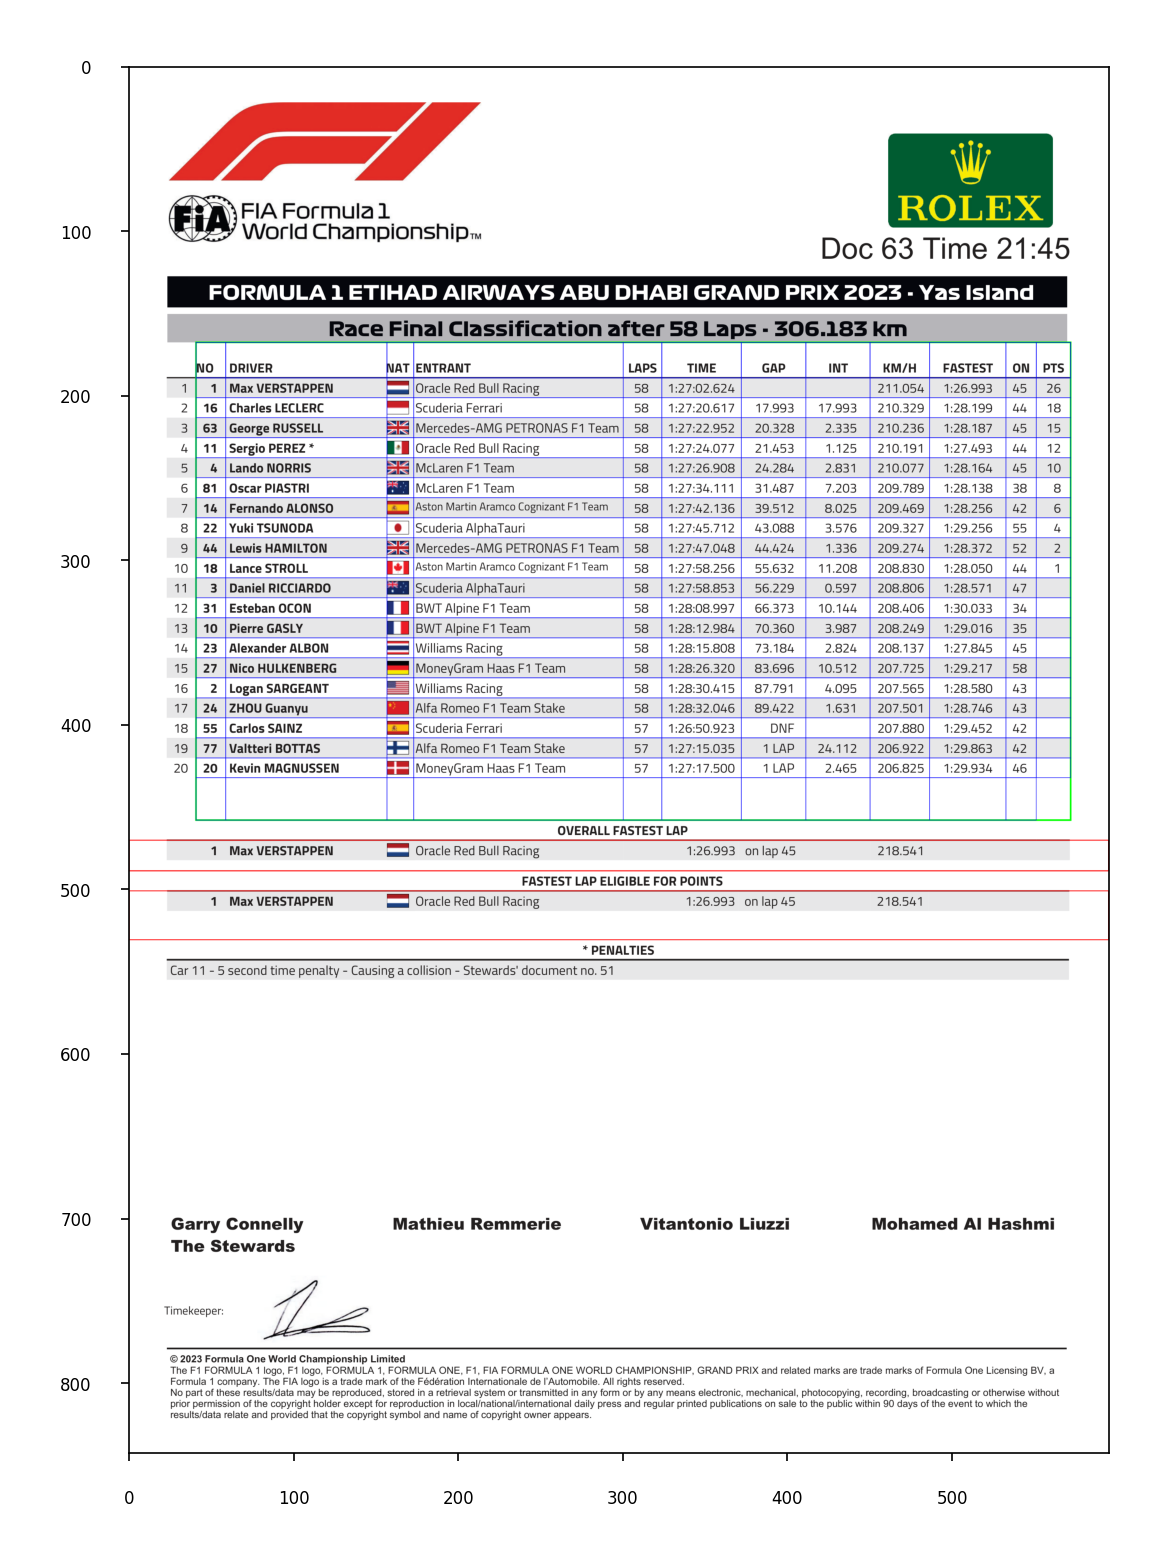

In [33]:
# Find the positions of "OVERALL FASTEST LAP" and "FASTEST LAP ELIGIBLE FOR POINTS"
t = page.search_for('OVERALL FASTEST LAP')[0].y1
b = page.search_for('FASTEST LAP ELIGIBLE FOR POINTS')[0].y0
fastest_lap = page.get_text('block', clip=fitz.Rect(0, t, w, b)).strip()
print(fastest_lap)
page.draw_rect(fitz.Rect(0, t, w, b), color=fitz.pdfcolor['red'], width=0.5)
show_image(page)

### Fastest Lap eligible for points

Same intuition: the text is betweem "FASTEST LAP ELIGIBLE FOR POINTS" and "PENALTIES".

1
Max VERSTAPPEN
Oracle Red Bull Racing
1:26.993  on lap 45
218.541


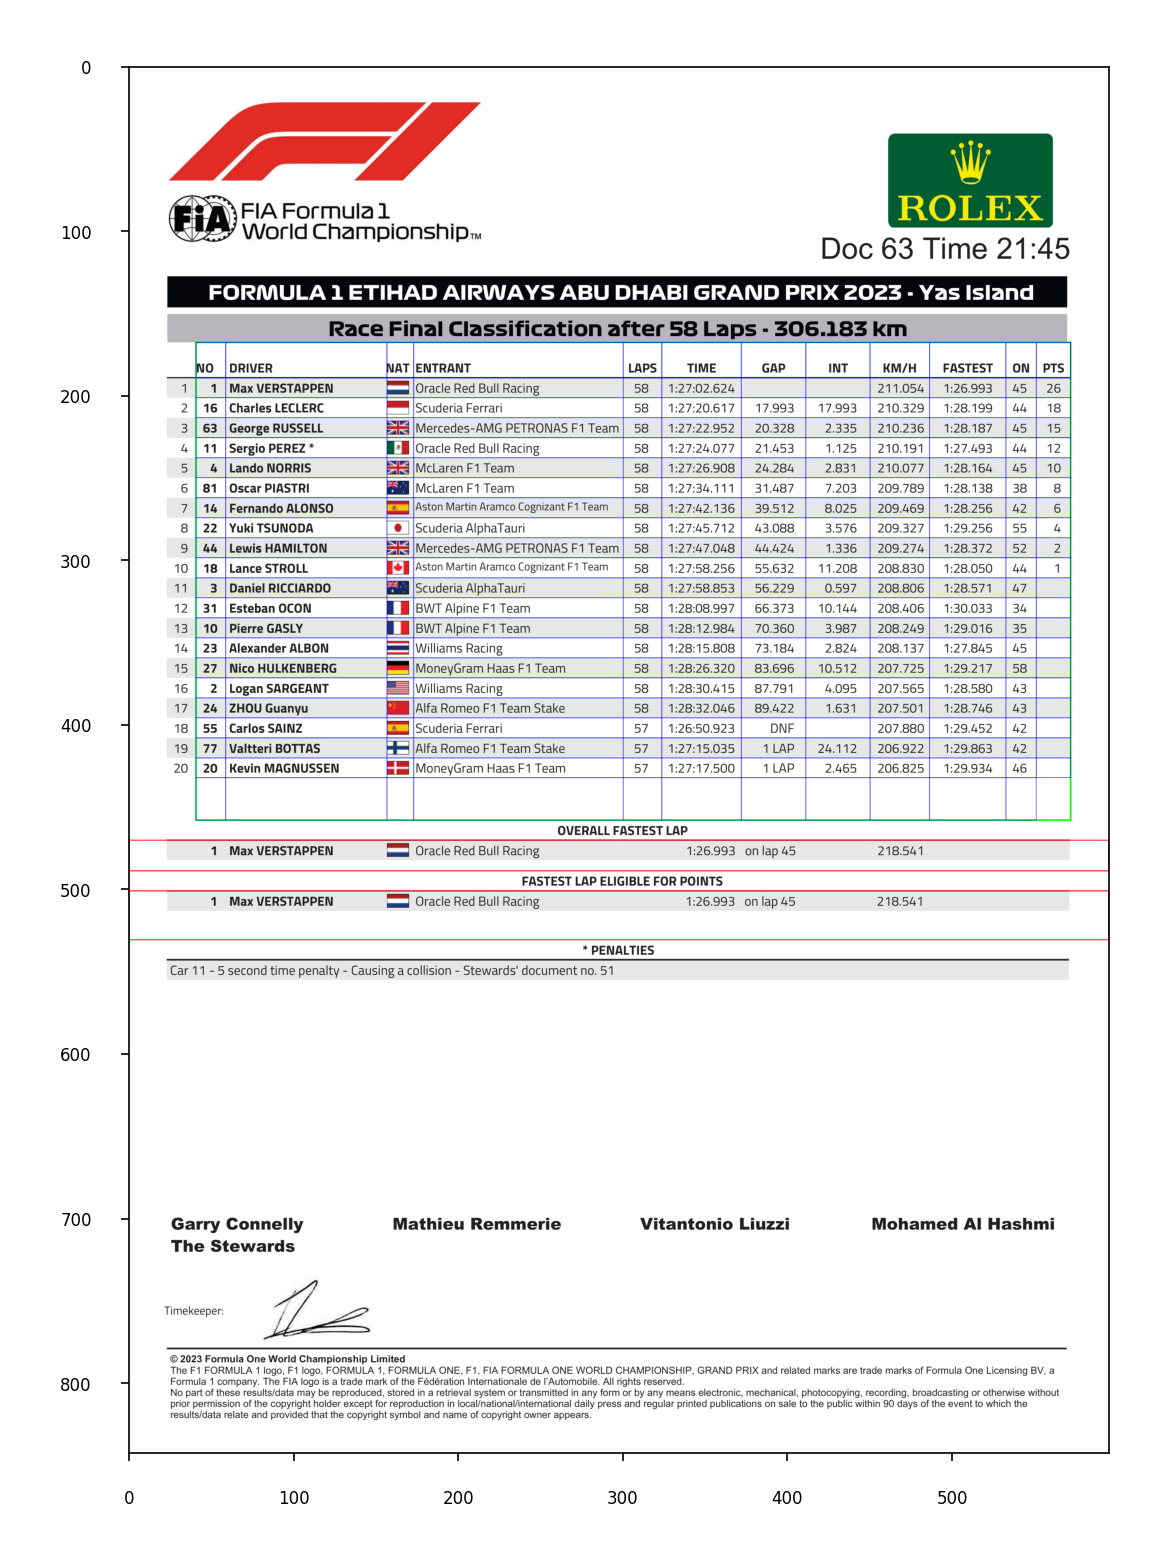

In [34]:
t = page.search_for('FASTEST LAP ELIGIBLE FOR POINTS')[0].y1
b = page.search_for('PENALTIES')[0].y0
fastest_lap = page.get_text('block', clip=fitz.Rect(0, t, w, b)).strip()
print(fastest_lap)
page.draw_rect(fitz.Rect(0, t, w, b), color=fitz.pdfcolor['red'], width=0.5)
show_image(page)

## Penalties

Everything below "PENALTIES" and above "Timekeeper". We may accidentally include the stewards, but in a penalty there must be a decision document number, which is basically some digits, while stewards' names will not have digits, so can easily remove them.

Car 11 - 5 second time penalty - Causing a collision - Stewards' document no. 51
Garry Connelly
        Mathieu Remmerie
          Vitantonio Liuzzi
         Mohamed Al Hashmi 
The Stewards


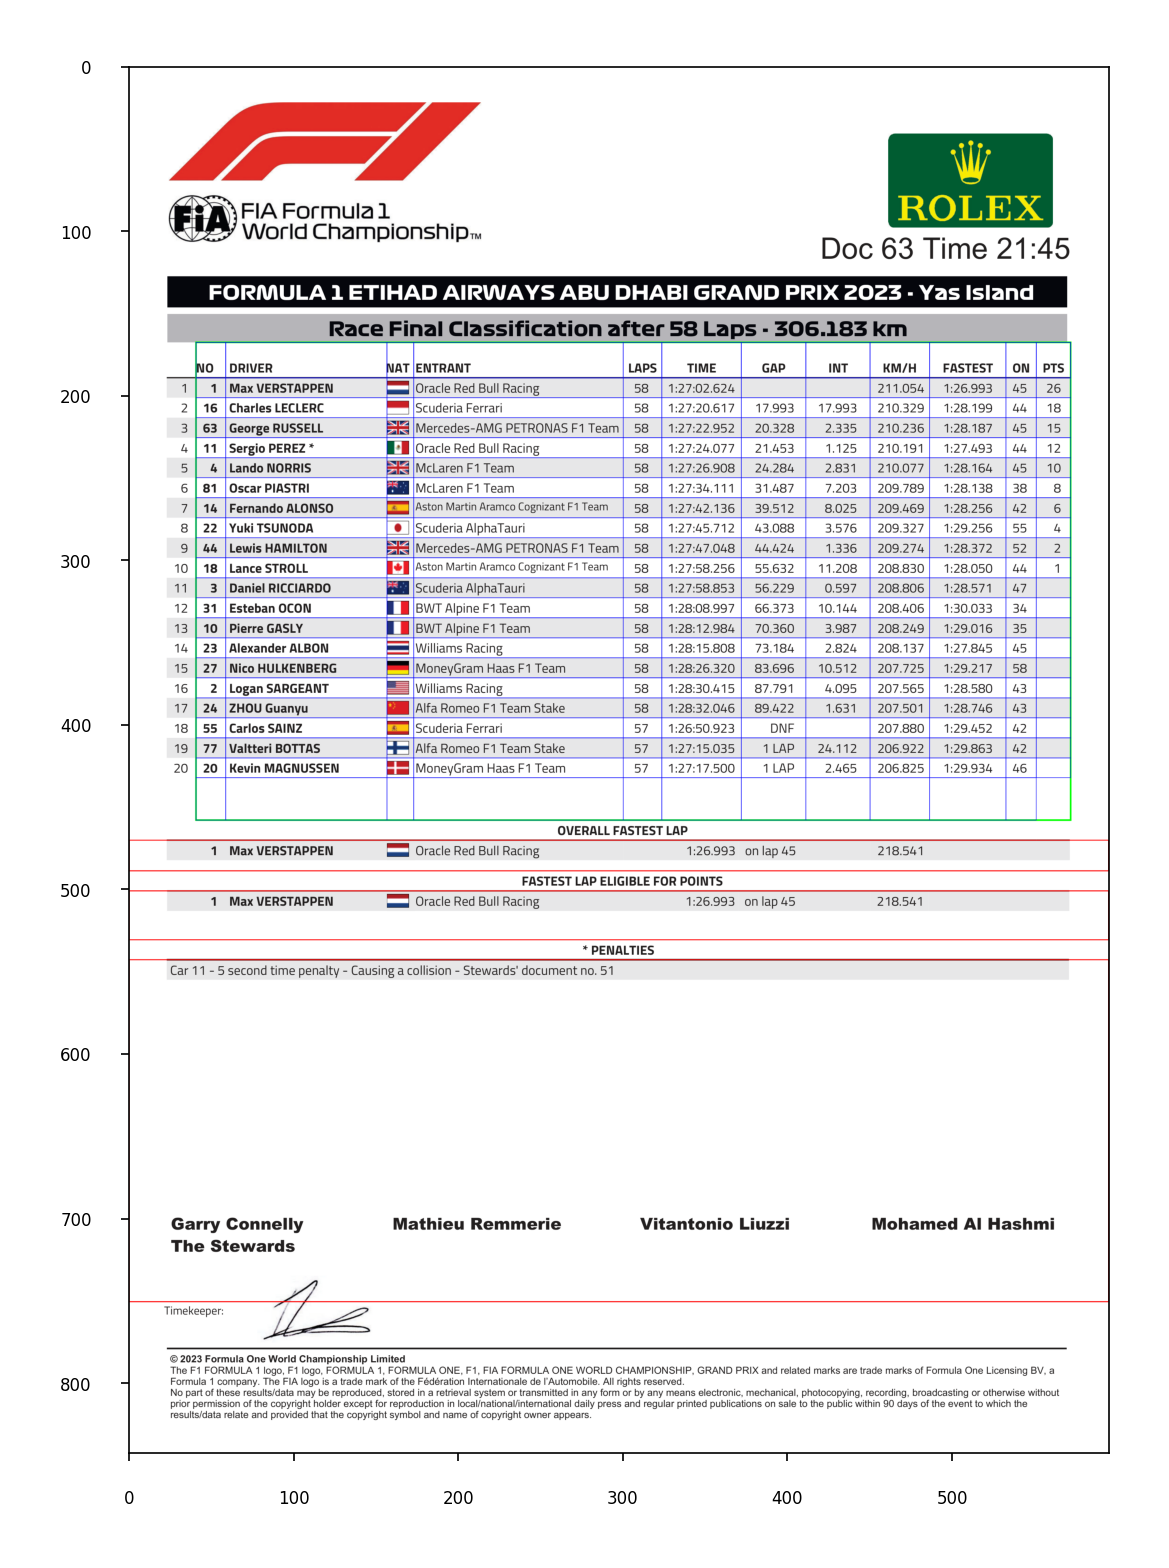

In [36]:
t = page.search_for('PENALTIES')[0].y1
b = page.search_for('Timekeeper')[0].y0
penalties = page.get_text('block', clip=fitz.Rect(0, t, w, b)).strip()
page.draw_rect(fitz.Rect(0, t, w, b), color=fitz.pdfcolor['red'], width=0.5)
print(penalties)
show_image(page)

In [37]:
for i in penalties.split('\n'):
    if re.findall(r'\d+', i):
        print(i)

Car 11 - 5 second time penalty - Causing a collision - Stewards' document no. 51


## Race Best Sector

Find "Sector $i$" and "Sector $i + 1$" (or the right edge of the page). The table for sector $i$ is below the two words, and bounded between the left of "Sector $i$" and the left of "Sector $i + 1$".

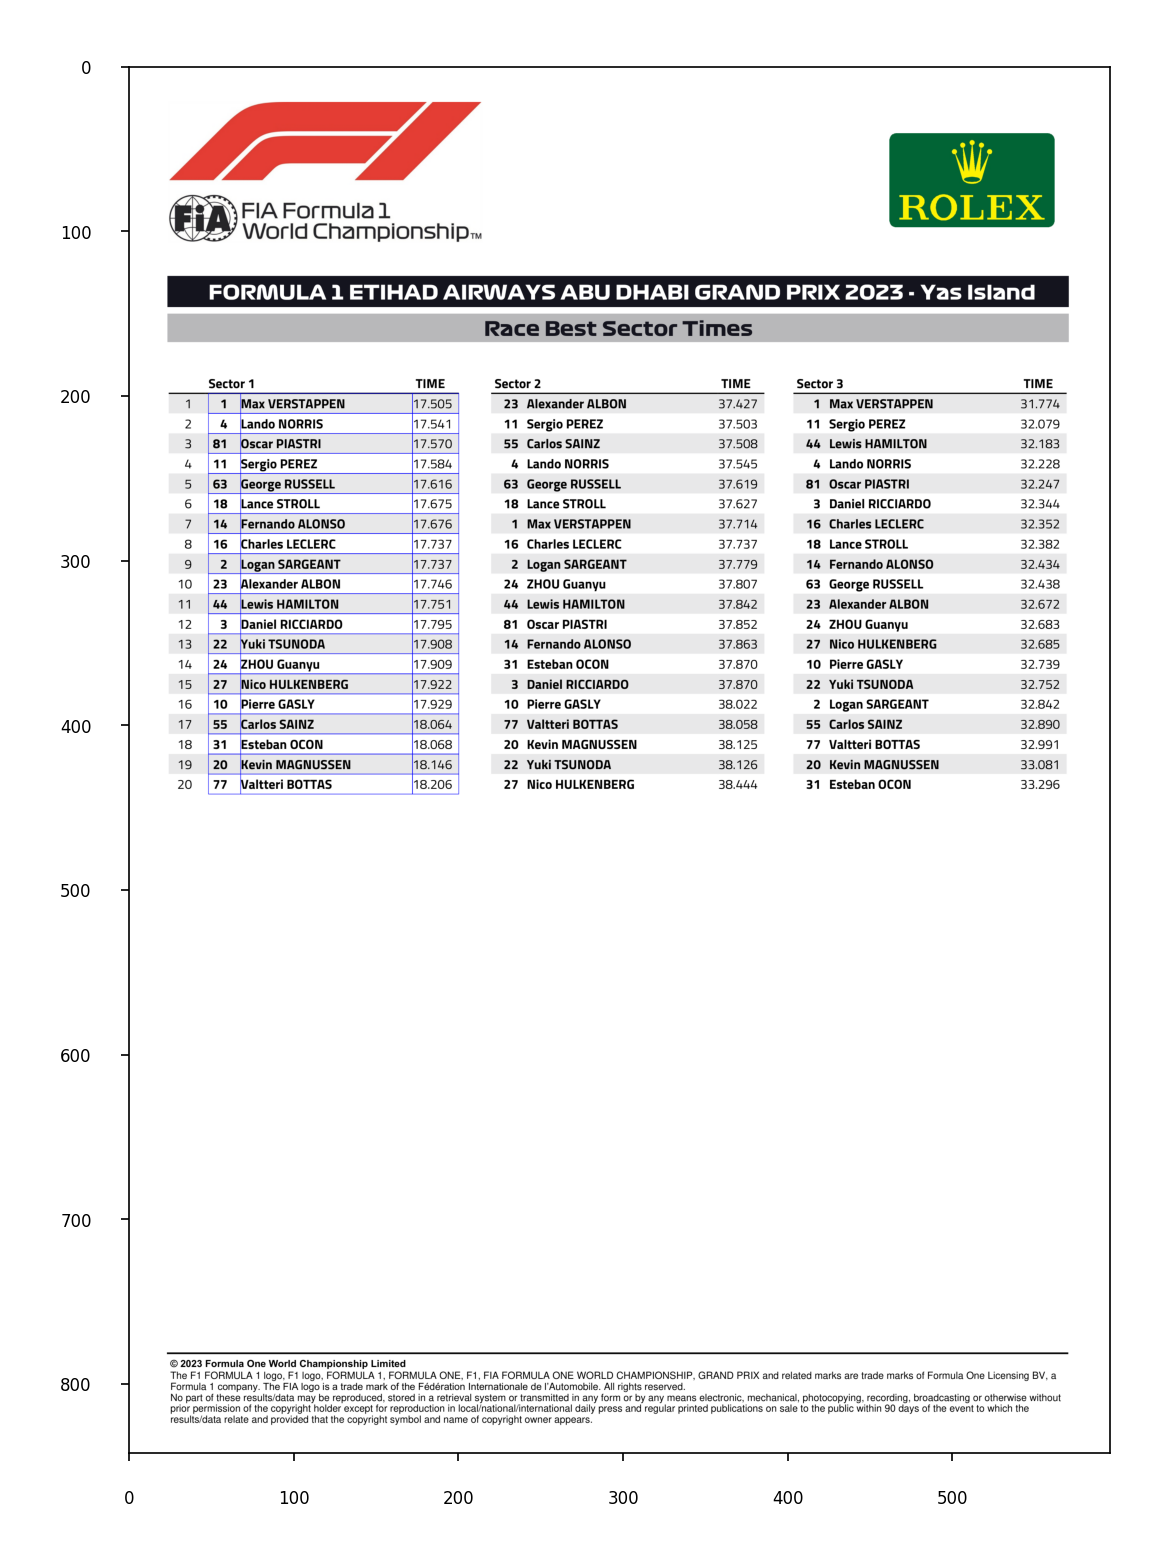

In [38]:
doc = fitz.open('../race_best_sector_times.pdf')
page = doc[0]

# Find "Sector 1" and "TIME"
sector = page.search_for('Sector 1')[0]
t = sector.y1
l = sector.x0
r = page.search_for('Sector 2')[0].x0

# Find the total height of the page
b = page.bound()[3]

# Find the table below "Sector 1" and "TIME"
tab = page.find_tables(clip=fitz.Rect(l, t, r, b), strategy='lines',
                       add_lines=[((l, 0), (l, b))])[0]
for cell in tab.cells:
    page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

In [41]:
df = tab.to_pandas()
df.index += 1  # Didn't parse the header correctly, and the winner is treated as the header. Fix it
df.iloc[0] = df.columns
df.columns = ['NO', 'DRIVER', 'TIME']
df

NO            DRIVER    TIME
1    1    Max VERSTAPPEN  17.505
2   81     Oscar PIASTRI  17.570
3   11      Sergio PEREZ  17.584
4   63    George RUSSELL  17.616
5   18      Lance STROLL  17.675
6   14   Fernando ALONSO  17.676
7   16   Charles LECLERC  17.737
8    2    Logan SARGEANT  17.737
9   23   Alexander ALBON  17.746
10  44    Lewis HAMILTON  17.751
11   3  Daniel RICCIARDO  17.795
12  22      Yuki TSUNODA  17.908
13  24       ZHOU Guanyu  17.909
14  27   Nico HULKENBERG  17.922
15  10      Pierre GASLY  17.929
16  55      Carlos SAINZ  18.064
17  31      Esteban OCON  18.068
18  20   Kevin MAGNUSSEN  18.146
19  77   Valtteri BOTTAS  18.206

## Race Fastest Laps

Very similar with Race Final Classification.

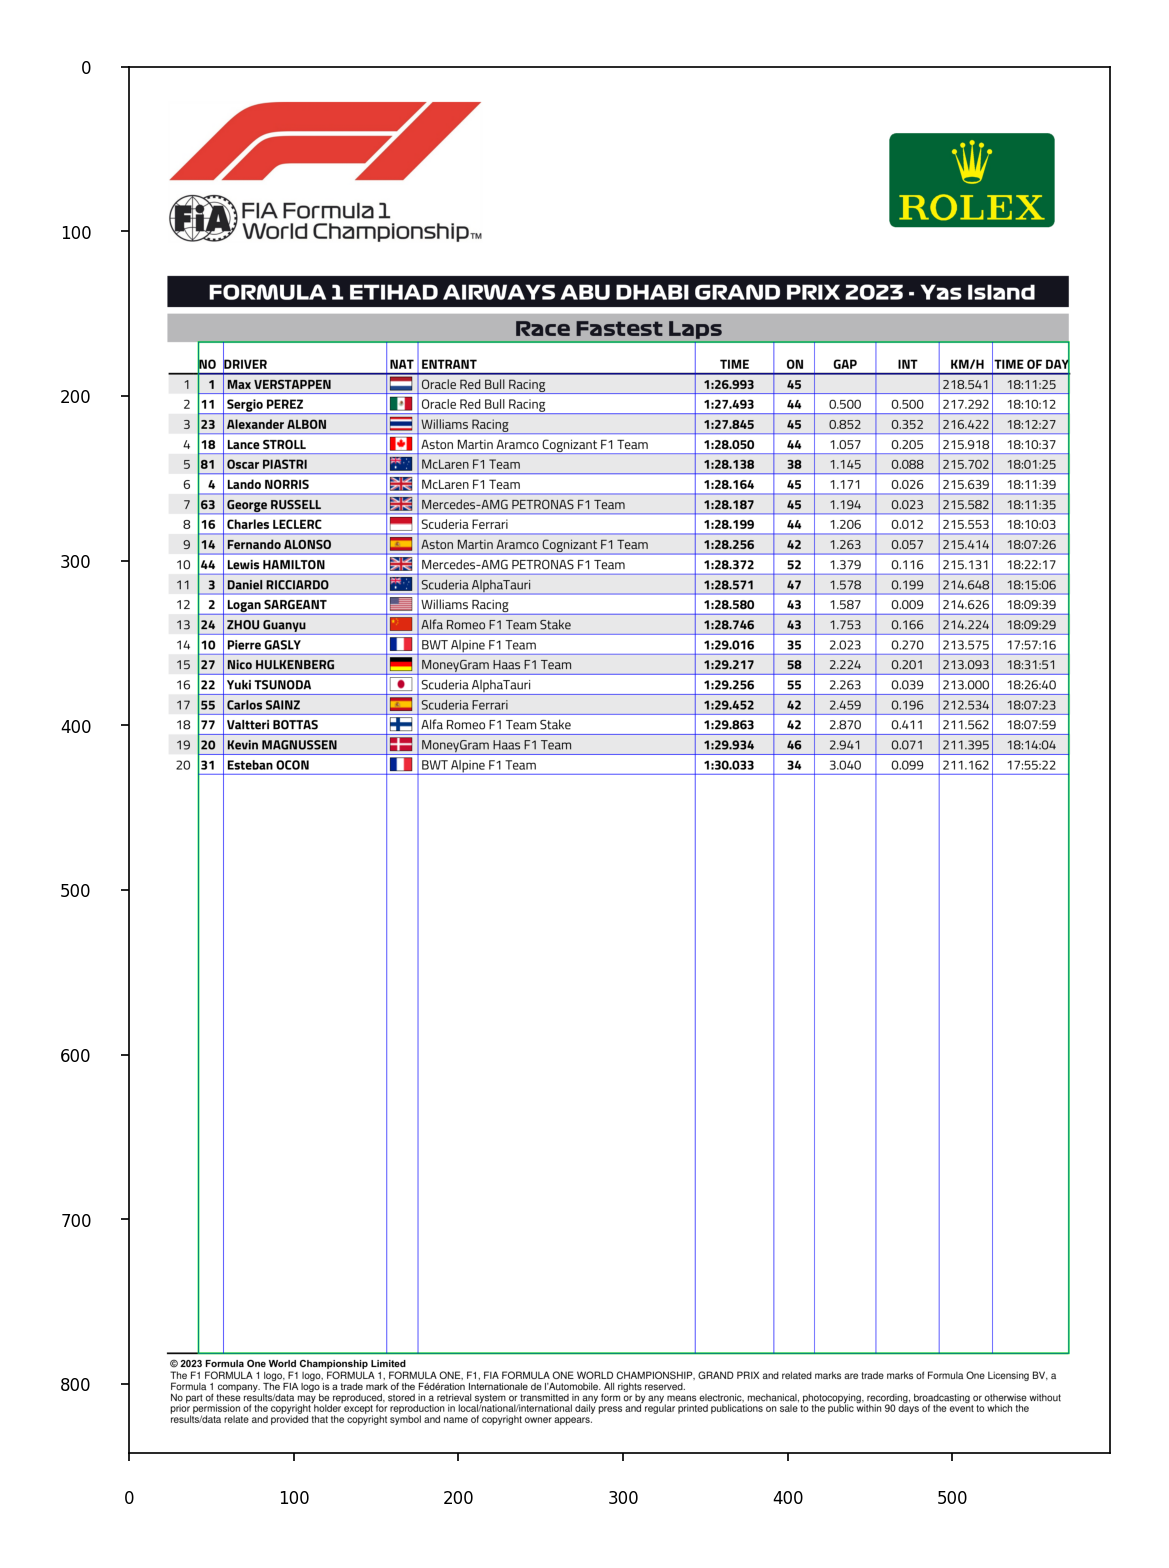

In [42]:
doc = fitz.open('../race_fastest_laps.pdf')
page = doc[0]

# Height and width of the page
h, w = page.bound()[3], page.bound()[2]

# Find "Race Fastest Lap"
t = page.search_for('Race Fastest Laps')[0].y1

# Find "TIME OF DAY"
b = page.search_for('TIME OF DAY')[0].y1

# Positions of table headers/column names
bbox = fitz.Rect(0, t, w, b)
pos = {}
for col in ['NO', 'DRIVER', 'NAT', 'ENTRANT', 'TIME', 'ON', 'GAP', 'INT', 'KM/H', 'TIME OF DAY']:
    pos[col] = {
        'left': page.search_for(col, clip=bbox)[0].x0,
        'right': page.search_for(col, clip=bbox)[0].x1
    }

# Lines separating the columns
aux_lines = [
    pos['NO']['left'],
    pos['DRIVER']['left'],
    pos['NAT']['left'],
    pos['NAT']['right'],
    pos['TIME']['left'] - (pos['TIME']['right'] - pos['TIME']['left']),
    (pos['TIME']['right'] + pos['ON']['left']) / 2,
    (pos['ON']['right'] + pos['GAP']['left']) / 2,
    (pos['GAP']['right'] + pos['INT']['left']) / 2,
    (pos['INT']['right'] + pos['KM/H']['left']) / 2,
    pos['TIME OF DAY']['left'],
    pos['TIME OF DAY']['right']
]


# Find the table below "Race Final Classification"
tab = page.find_tables(
    clip=fitz.Rect(pos['NO']['left'], t, pos['TIME OF DAY']['right'], h),
    strategy='lines',
    vertical_lines=aux_lines,
    snap_x_tolerance=pos['ENTRANT']['left'] - pos['NAT']['right']
)[0]

# Mark the tables for visualisation
page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
for cell in tab.cells:
    page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

In [43]:
tab.to_pandas()

NO            DRIVER NAT                                ENTRANT      TIME  \
0    1    Max VERSTAPPEN                     Oracle Red Bull Racing  1:26.993   
1   11      Sergio PEREZ                     Oracle Red Bull Racing  1:27.493   
2   23   Alexander ALBON                            Williams Racing  1:27.845   
3   18      Lance STROLL      Aston Martin Aramco Cognizant F1 Team  1:28.050   
4   81     Oscar PIASTRI                            McLaren F1 Team  1:28.138   
5    4      Lando NORRIS                            McLaren F1 Team  1:28.164   
6   63    George RUSSELL              Mercedes-AMG PETRONAS F1 Team  1:28.187   
7   16   Charles LECLERC                           Scuderia Ferrari  1:28.199   
8   14   Fernando ALONSO      Aston Martin Aramco Cognizant F1 Team  1:28.256   
9   44    Lewis HAMILTON              Mercedes-AMG PETRONAS F1 Team  1:28.372   
10   3  Daniel RICCIARDO                        Scuderia AlphaTauri  1:28.571   
11   2    Logan SARGEANT                            Williams Racing  1:28.580   
12  24       ZHOU Guanyu                   Alfa Romeo F1 Team Stake  1:28.746   
13  10      Pierre GASLY                         BWT Alpine F1 Team  1:29.016   
14  27   Nico HULKENBERG                     MoneyGram Haas F1 Team  1:29.217   
15  22      Yuki TSUNODA                        Scuderia AlphaTauri  1:29.256   
16  55      Carlos SAINZ                           Scuderia Ferrari  1:29.452   
17  77   Valtteri BOTTAS                   Alfa Romeo F1 Team Stake  1:29.863   
18  20   Kevin MAGNUSSEN                     MoneyGram Haas F1 Team  1:29.934   
19  31      Esteban OCON                         BWT Alpine F1 Team  1:30.033   
20                                                                              

    ON    GAP    INT     KM/H TIME OF DAY  
0   45                218.541    18:11:25  
1   44  0.500  0.500  217.292    18:10:12  
2   45  0.852  0.352  216.422    18:12:27  
3   44  1.057  0.205  215.918    18:10:37  
4   38  1.145  0.088  215.702    18:01:25  
5   45  1.171  0.026  215.639    18:11:39  
6   45  1.194  0.023  215.582    18:11:35  
7   44  1.206  0.012  215.553    18:10:03  
8   42  1.263  0.057  215.414    18:07:26  
9   52  1.379  0.116  215.131    18:22:17  
10  47  1.578  0.199  214.648    18:15:06  
11  43  1.587  0.009  214.626    18:09:39  
12  43  1.753  0.166  214.224    18:09:29  
13  35  2.023  0.270  213.575    17:57:16  
14  58  2.224  0.201  213.093    18:31:51  
15  55  2.263  0.039  213.000    18:26:40  
16  42  2.459  0.196  212.534    18:07:23  
17  42  2.870  0.411  211.562    18:07:59  
18  46  2.941  0.071  211.395    18:14:04  
19  34  3.040  0.099  211.162    17:55:22  
20

## Race History Chart

There are multiple tables in each page, all of which are below "Race History Chart". The table for lap $i$ is horizontally bounded between "Lap $i$" and "Lap $i + 1$" (or the right border of the page).

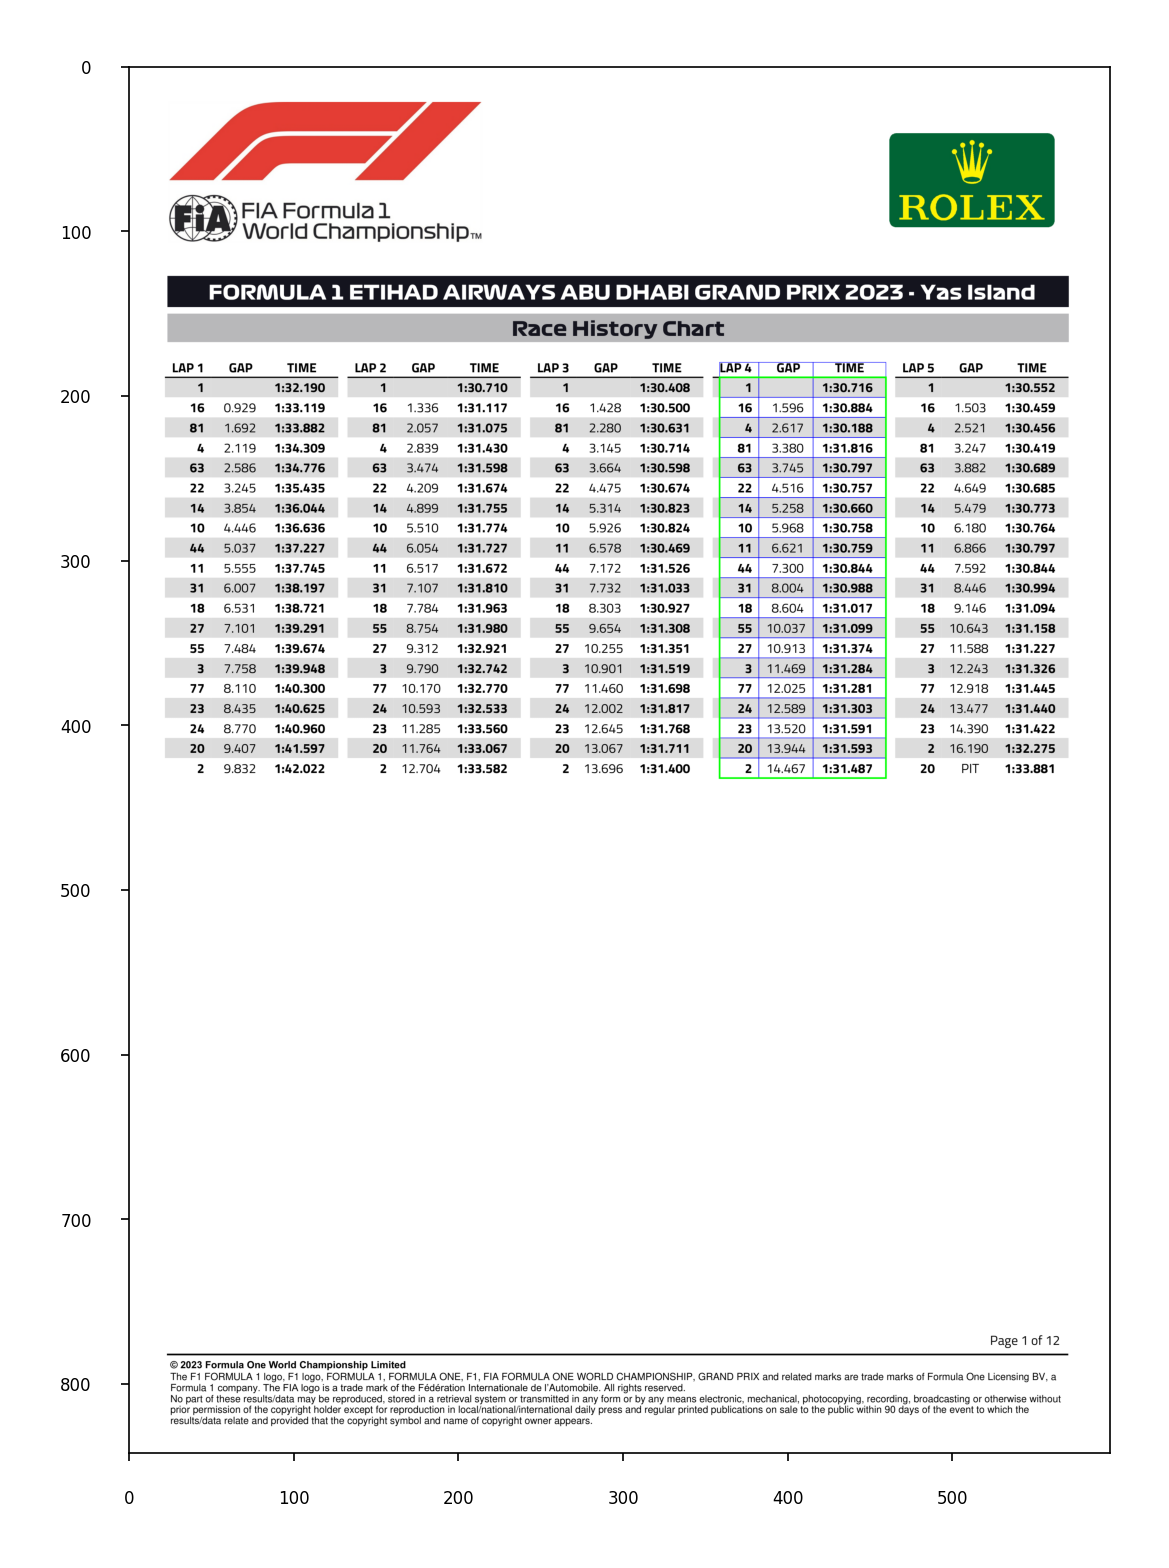

In [44]:
doc = fitz.open('../race_history_chart.pdf')
page = doc[0]

# Find "Race History Chart"
t = page.search_for('Race History Chart')[0].y1

# Page width and height
w, h = page.bound()[2], page.bound()[3]

# Find the table for lap 4 as an example
for i in range(4, 5):

    # Find "Lap 4"
    l = page.search_for(f'Lap {i}')[0].x0

    # Find "Lap 5"
    if page.search_for(f'Lap {i + 1}'):
        r = page.search_for(f'Lap {i + 1}')[0].x0
    else:
        r = w

    # Find tables in the bounding box of driver i's table
    tab = page.find_tables(clip=fitz.Rect(l, t, r, h), strategy='lines',
                           add_lines=[((l, 0), (l, h))])[0]

    # Mark the tables for visualisation
    for cell in tab.header.cells:
        page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])

show_image(page)

In [45]:
tab.to_pandas()

LAP 4     GAP      TIME
0      1          1:30.716
1     16   1.596  1:30.884
2      4   2.617  1:30.188
3     81   3.380  1:31.816
4     63   3.745  1:30.797
5     22   4.516  1:30.757
6     14   5.258  1:30.660
7     10   5.968  1:30.758
8     11   6.621  1:30.759
9     44   7.300  1:30.844
10    31   8.004  1:30.988
11    18   8.604  1:31.017
12    55  10.037  1:31.099
13    27  10.913  1:31.374
14     3  11.469  1:31.284
15    77  12.025  1:31.281
16    24  12.589  1:31.303
17    23  13.520  1:31.591
18    20  13.944  1:31.593
19     2  14.467  1:31.487

## Race Maximum Speeds

A table is horizontally bounded between words like "FINISH LINE" and "KM/H". To help parsing, we add column seprators at the table's left border, the left of "KM/H", and the right border of the table.

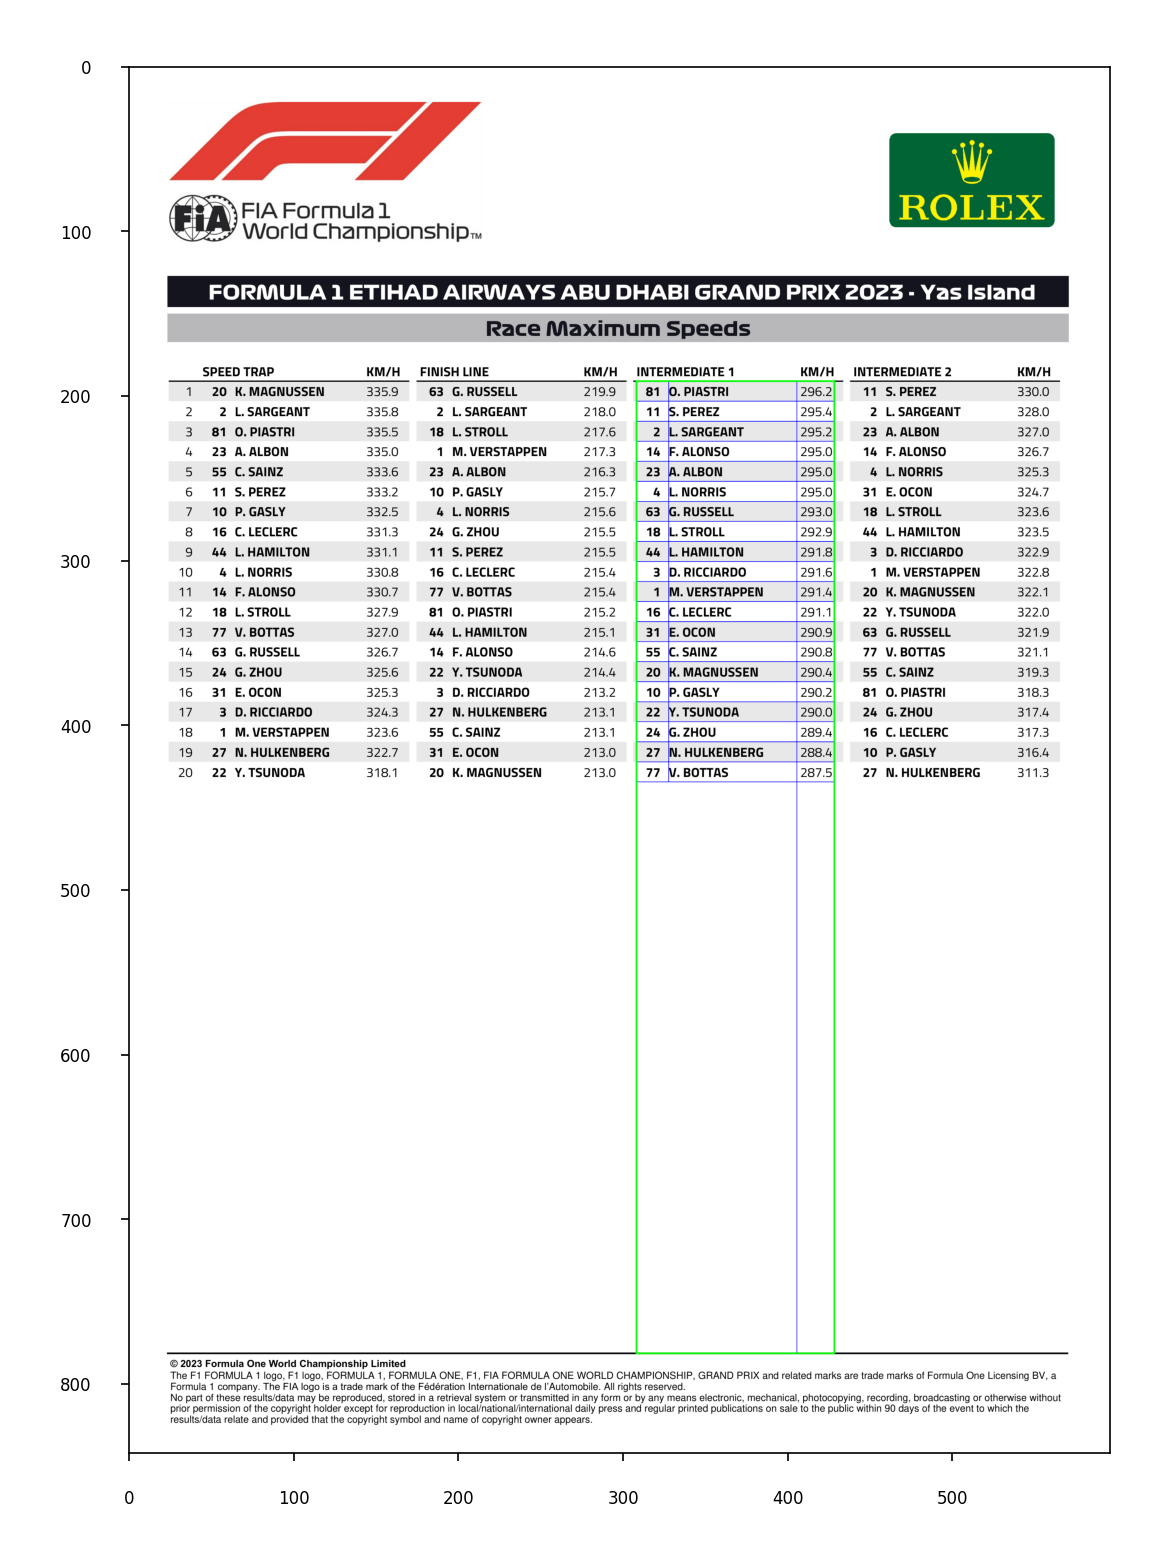

In [46]:
doc = fitz.open('../race_maximum_speeds.pdf')
page = doc[0]

# Find "KM/H"
t = page.search_for('KM/H')[0].y0

# Page width and height
w, h = page.bound()[2], page.bound()[3]
tabs = page.find_tables(clip=fitz.Rect(0, t, w, h), strategy='lines')

# Search for the table of "Intermediate 1"
for i in ['INTERMEDIATE 1']:
    l = page.search_for(i)[0].x0
    kmh = page.search_for('KM/H', clip=fitz.Rect(l, t, w, h))[0]
    r = kmh.x1
    aux_lines = [
        ((kmh.x0, t), (kmh.x0, h)),
        ((r, t), (r, h))
    ]
    tab = page.find_tables(clip=fitz.Rect(l, t, r, h), strategy='lines',
                           vertical_lines=[l, kmh.x0, r])[0]
    for cell in tab.cells:
        page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])

show_image(page)

Again, the header is lost so add it manually.

In [50]:
df = tab.to_pandas()
df.index += 1  # Didn't parse the header correctly, and the winner is treated as the header. Fix it
df.iloc[0] = df.columns
df.columns = ['NO', 'DRIVER', 'KM/H']
df.dropna(subset='DRIVER')

NO         DRIVER   KM/H
1   81     O. PIASTRI  296.2
2    2    L. SARGEANT  295.2
3   14      F. ALONSO  295.0
4   23       A. ALBON  295.0
5    4      L. NORRIS  295.0
6   63     G. RUSSELL  293.0
7   18      L. STROLL  292.9
8   44    L. HAMILTON  291.8
9    3   D. RICCIARDO  291.6
10   1  M. VERSTAPPEN  291.4
11  16     C. LECLERC  291.1
12  31        E. OCON  290.9
13  55       C. SAINZ  290.8
14  20   K. MAGNUSSEN  290.4
15  10       P. GASLY  290.2
16  22     Y. TSUNODA  290.0
17  24        G. ZHOU  289.4
18  27  N. HULKENBERG  288.4
19  77      V. BOTTAS  287.5

## Race Pit Stop Summary

The table is below "Race Pit Stop Summary". The columns are separated by the left border of the page, and of the words "NO", "DRIVER", "ENTRANT", "LAP", "TIME OF DAY", "STOP", "DURATION", "TOTAL TIME", and right border of the page.

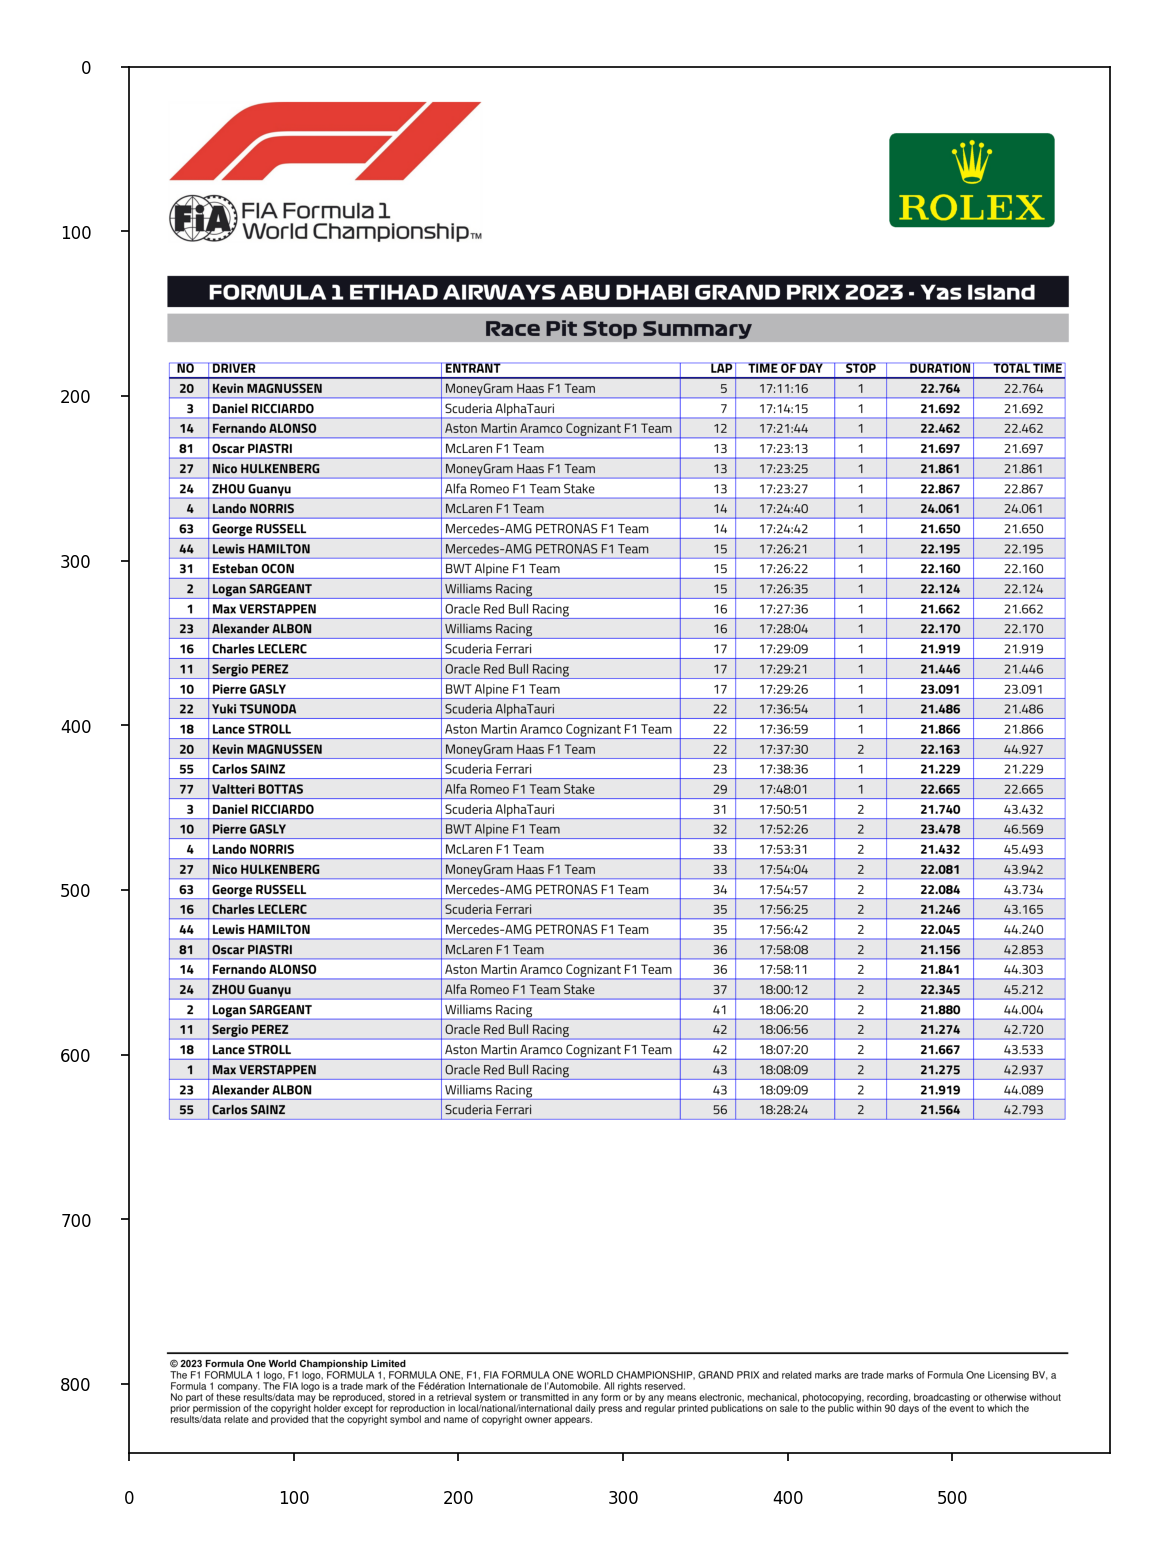

In [53]:
doc = fitz.open('../race_pit_stop_summary.pdf')
page = doc[0]

# Find "Race Pit Stop Summary"
t = page.search_for('DRIVER')[0].y0

# Page width and height
w, h = page.bound()[2], page.bound()[3]

tabs = page.find_tables(clip=fitz.Rect(0, t, w, h), strategy='lines')
for tab in tabs:
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

In [52]:
tabs[0].to_pandas()

NO            DRIVER                                ENTRANT LAP  \
0   20   Kevin MAGNUSSEN                 MoneyGram Haas F1 Team   5   
1    3  Daniel RICCIARDO                    Scuderia AlphaTauri   7   
2   14   Fernando ALONSO  Aston Martin Aramco Cognizant F1 Team  12   
3   81     Oscar PIASTRI                        McLaren F1 Team  13   
4   27   Nico HULKENBERG                 MoneyGram Haas F1 Team  13   
5   24       ZHOU Guanyu               Alfa Romeo F1 Team Stake  13   
6    4      Lando NORRIS                        McLaren F1 Team  14   
7   63    George RUSSELL          Mercedes-AMG PETRONAS F1 Team  14   
8   44    Lewis HAMILTON          Mercedes-AMG PETRONAS F1 Team  15   
9   31      Esteban OCON                     BWT Alpine F1 Team  15   
10   2    Logan SARGEANT                        Williams Racing  15   
11   1    Max VERSTAPPEN                 Oracle Red Bull Racing  16   
12  23   Alexander ALBON                        Williams Racing  16   
13  16   Charles LECLERC                       Scuderia Ferrari  17   
14  11      Sergio PEREZ                 Oracle Red Bull Racing  17   
15  10      Pierre GASLY                     BWT Alpine F1 Team  17   
16  22      Yuki TSUNODA                    Scuderia AlphaTauri  22   
17  18      Lance STROLL  Aston Martin Aramco Cognizant F1 Team  22   
18  20   Kevin MAGNUSSEN                 MoneyGram Haas F1 Team  22   
19  55      Carlos SAINZ                       Scuderia Ferrari  23   
20  77   Valtteri BOTTAS               Alfa Romeo F1 Team Stake  29   
21   3  Daniel RICCIARDO                    Scuderia AlphaTauri  31   
22  10      Pierre GASLY                     BWT Alpine F1 Team  32   
23   4      Lando NORRIS                        McLaren F1 Team  33   
24  27   Nico HULKENBERG                 MoneyGram Haas F1 Team  33   
25  63    George RUSSELL          Mercedes-AMG PETRONAS F1 Team  34   
26  16   Charles LECLERC                       Scuderia Ferrari  35   
27  44    Lewis HAMILTON          Mercedes-AMG PETRONAS F1 Team  35   
28  81     Oscar PIASTRI                        McLaren F1 Team  36   
29  14   Fernando ALONSO  Aston Martin Aramco Cognizant F1 Team  36   
30  24       ZHOU Guanyu               Alfa Romeo F1 Team Stake  37   
31   2    Logan SARGEANT                        Williams Racing  41   
32  11      Sergio PEREZ                 Oracle Red Bull Racing  42   
33  18      Lance STROLL  Aston Martin Aramco Cognizant F1 Team  42   
34   1    Max VERSTAPPEN                 Oracle Red Bull Racing  43   
35  23   Alexander ALBON                        Williams Racing  43   
36  55      Carlos SAINZ                       Scuderia Ferrari  56   

   TIME OF DAY STOP DURATION TOTAL TIME  
0     17:11:16    1   22.764     22.764  
1     17:14:15    1   21.692     21.692  
2     17:21:44    1   22.462     22.462  
3     17:23:13    1   21.697     21.697  
4     17:23:25    1   21.861     21.861  
5     17:23:27    1   22.867     22.867  
6     17:24:40    1   24.061     24.061  
7     17:24:42    1   21.650     21.650  
8     17:26:21    1   22.195     22.195  
9     17:26:22    1   22.160     22.160  
10    17:26:35    1   22.124     22.124  
11    17:27:36    1   21.662     21.662  
12    17:28:04    1   22.170     22.170  
13    17:29:09    1   21.919     21.919  
14    17:29:21    1   21.446     21.446  
15    17:29:26    1   23.091     23.091  
16    17:36:54    1   21.486     21.486  
17    17:36:59    1   21.866     21.866  
18    17:37:30    2   22.163     44.927  
19    17:38:36    1   21.229     21.229  
20    17:48:01    1   22.665     22.665  
21    17:50:51    2   21.740     43.432  
22    17:52:26    2   23.478     46.569  
23    17:53:31    2   21.432     45.493  
24    17:54:04    2   22.081     43.942  
25    17:54:57    2   22.084     43.734  
26    17:56:25    2   21.246     43.165  
27    17:56:42    2   22.045     44.240  
28    17:58:08    2   21.156     42.853  
29    17:58:11    2   21.841     44.303  
30 

## Race Lap Chart

This is probably the most structured table, but cannot be easily parsed, bc. some numbers are boxed and the boxes are essentially lines, which interfere with table structure detection. So instead, we don't use any vector graphics for parsing, but only use text positions, i.e. `strategy='text'`.

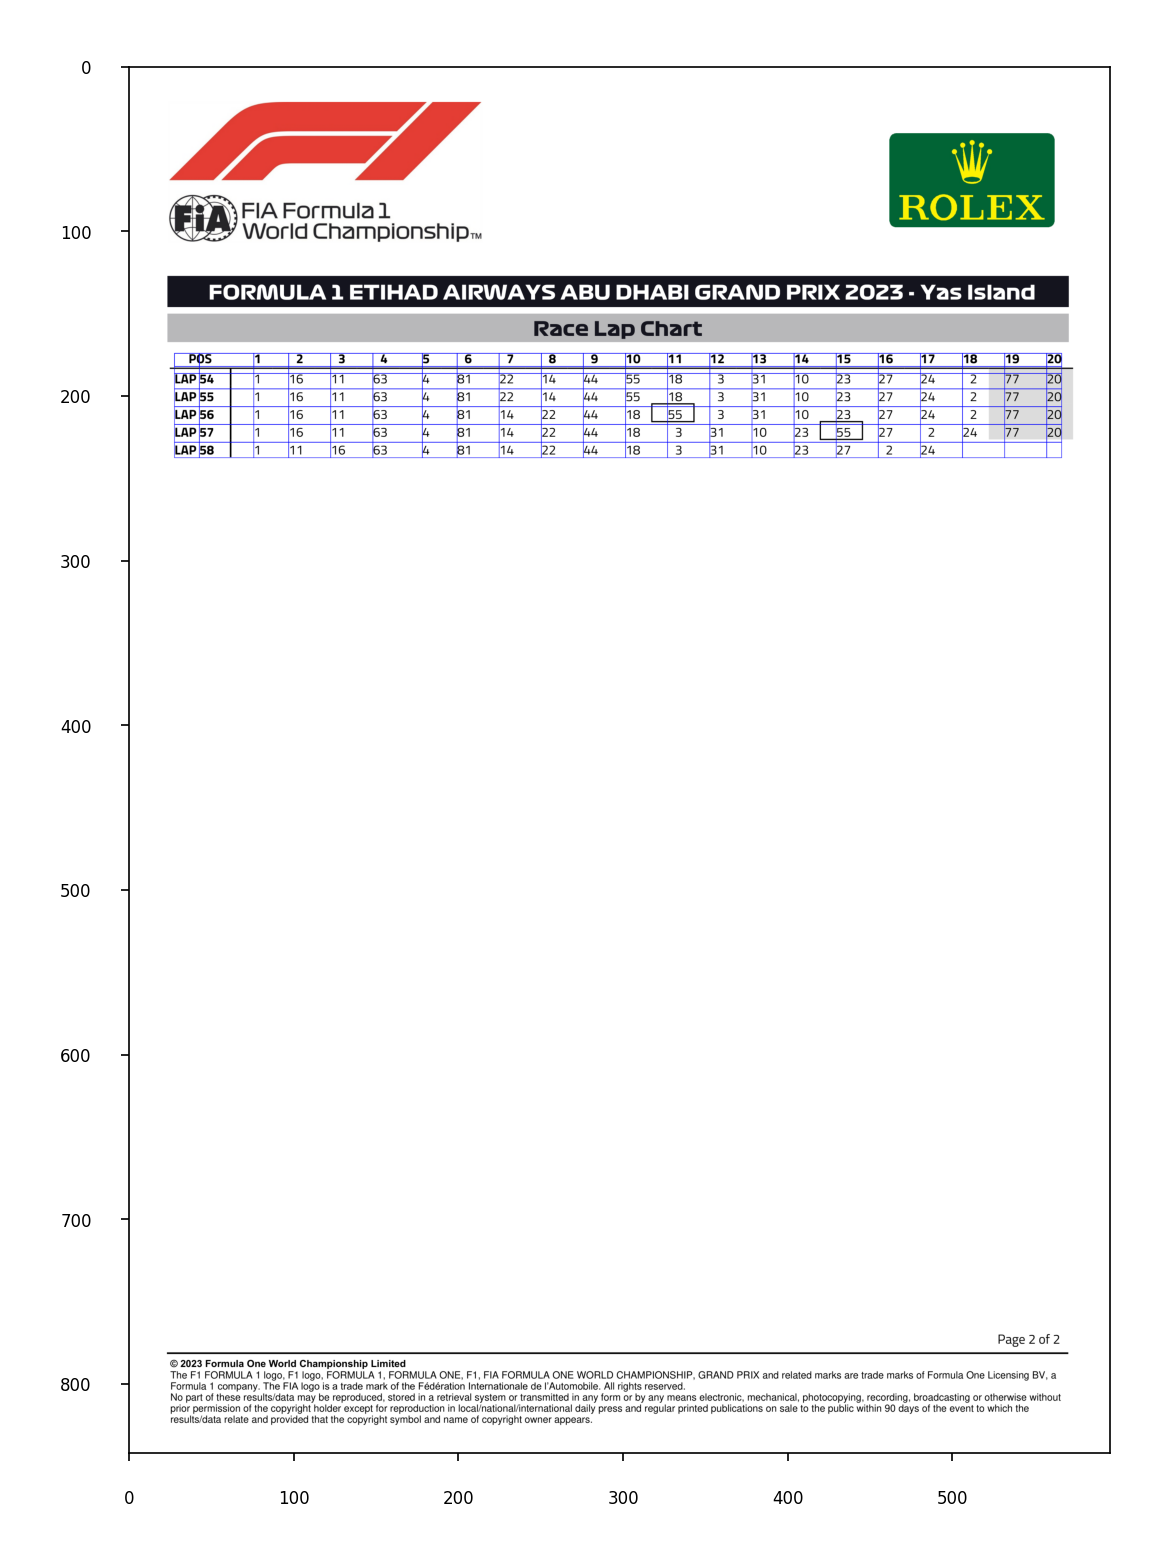

In [58]:
doc = fitz.open('../race_lap_chart.pdf')
page = doc[1]

# Find "POS"
t = page.search_for('POS')[0].y0

# Find "Page"
b = page.search_for('Page')[0].y0

# Page width
w = page.bound()[2]

tabs = page.find_tables(clip=fitz.Rect(0, t, w, b), strategy='text')
for tab in tabs:
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

We lose a bit in column 0 (e.g. get "AP 5" rather than "LAP 5), but that's fine. We only need the lap number, which is at most two digits, and thus definitely contained within the width of "POS". It's OK to lose "LAP".

In [59]:
tabs[0].to_pandas()

P  OS  1   2   3   4  5   6   7   8  ...  11  12  13  14  15  16  17  18  \
0                                         ...                                   
1  LAP  54  1  16  11  63  4  81  22  14  ...  18   3  31  10  23  27  24   2   
2  LAP  55  1  16  11  63  4  81  22  14  ...  18   3  31  10  23  27  24   2   
3  LAP  56  1  16  11  63  4  81  14  22  ...  55   3  31  10  23  27  24   2   
4  LAP  57  1  16  11  63  4  81  14  22  ...   3  31  10  23  55  27   2  24   
5  LAP  58  1  11  16  63  4  81  14  22  ...   3  31  10  23  27   2  24       

   19  20  
0          
1  77  20  
2  77  20  
3  77  20  
4  77  20  
5          

[6 rows x 22 columns]

## Power Unit Allocations

The rows and columns aren't separated by lines but instead empty spaces. The parser searches for the unique character of "N°" and the last character of the file which is located at the bottom right corner to create the bounding box surrouding the "table". From there, the library is able to detect the horizontal and vertical separation by using `horizontal_strategy='text'` and by providing it the vertical lines.

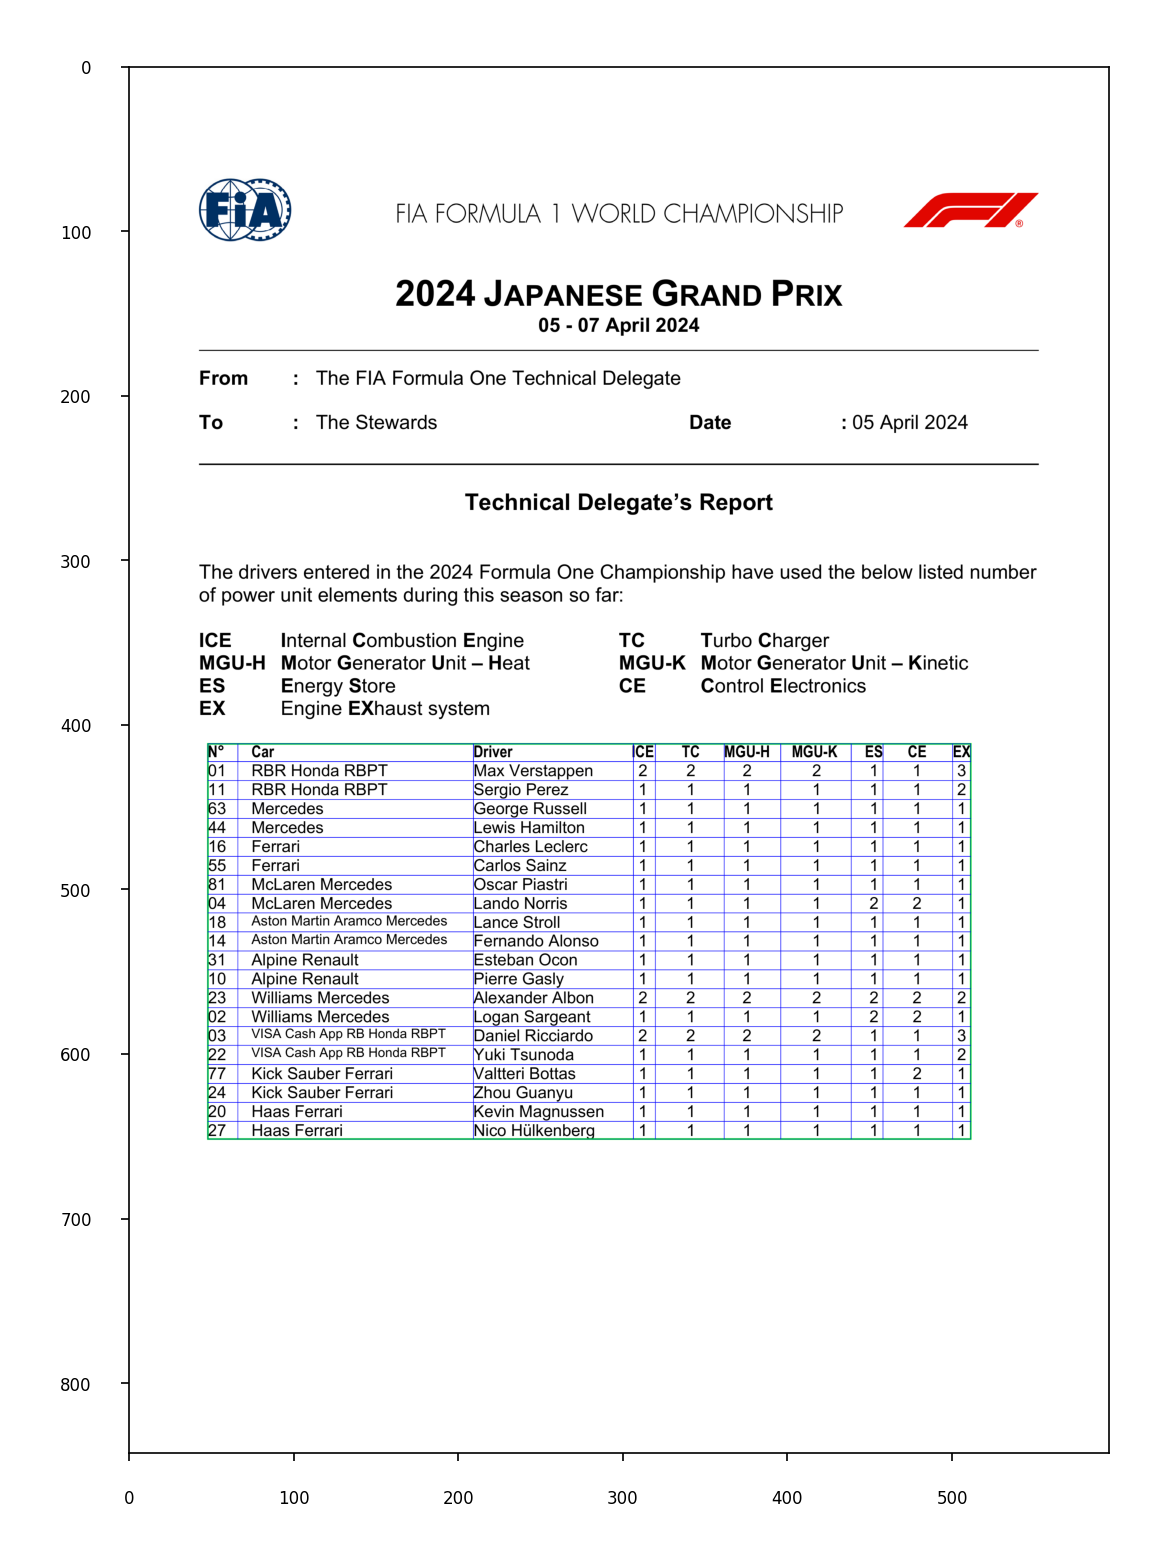

In [6]:
doc = fitz.open("../race_pu_elements_used.pdf")

# Find year/grand prix
page_0 = doc[0]

# Find "2024 Japanese Grand Prix" block
# The Block is a tuple with coordinates and text
text = page_0.get_text(option='blocks')
race = text[0][4].split()
year = race[0]
grand_prix = race[1:len(race)]
grand_prix_str = " ".join(grand_prix).title()

# Find Power Unit components table
page_1 = doc[1]

# Search the bounding box for the N° character
number = page_1.search_for('N°')

# Find the very last character in the table
# at the bottom right
text = page_1.get_text().strip()
lc = text[-1]

# Search the last bounding box for the last character
char_bbox = page_1.search_for(lc)[-1]

# Create bounding box surrounding the entire table
# add 5% extra buffer to the right boundary
bbox = fitz.Rect(number[0].x0, number[0].y0, char_bbox.x1 * 1.05, char_bbox.y1)

# Create dictionary with the columns left/right most coordinates
pos = {}
for col in ['N°','Car','Driver', 'ICE', 'TC', 'MGU-H', 'MGU-K', 'ES', 'CE', 'EX']:
    pos[col] = {
        'left': page_1.search_for(col, clip=bbox)[0].x0,
        'right': page_1.search_for(col, clip=bbox)[0].x1
    }

# Some lines had to be adjusted to help the table detection
aux_lines = [
    pos['N°']['left'],
    (pos['N°']['right'] + pos['Car']['left']) / 2,
    pos['Driver']['left'],
    pos['ICE']['left'],
    (pos['ICE']['left'] + pos['TC']['left']) / 2,
    pos['MGU-H']['left'],
    (pos['MGU-H']['right'] + pos['MGU-K']['left']) / 2,
    (pos['MGU-K']['right'] + pos['ES']['left']) / 2,
    pos['ES']['right'],
    pos['CE']['left'],
    pos['CE']['right'],
    pos['EX']['left'],
    pos['EX']['right']
]

tabs = page_1.find_tables(
    clip=fitz.Rect(bbox),
    horizontal_strategy='text',
    vertical_lines=aux_lines,
)

# Mark the tables for visualisation
for j, tab in enumerate(tabs):  # iterate over all tables
    page_1.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
    # print(tab.header.cells)
    for cell in tab.header.cells:
        page_1.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page_1.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)

show_image(page_1)

Manually add the parsed `Year` and `Grand Prix` to the dataframe.

In [7]:
df = tab.to_pandas()
df.insert(0, "Year", year)
df.insert(1, "Grand Prix", grand_prix_str)
display(df)

Year           Grand Prix  N°                           Car  \
0   2024  Japanese Grand Prix  01                RBR Honda RBPT   
1   2024  Japanese Grand Prix  11                RBR Honda RBPT   
2   2024  Japanese Grand Prix  63                      Mercedes   
3   2024  Japanese Grand Prix  44                      Mercedes   
4   2024  Japanese Grand Prix  16                       Ferrari   
5   2024  Japanese Grand Prix  55                       Ferrari   
6   2024  Japanese Grand Prix  81              McLaren Mercedes   
7   2024  Japanese Grand Prix  04              McLaren Mercedes   
8   2024  Japanese Grand Prix  18  Aston Martin Aramco Mercedes   
9   2024  Japanese Grand Prix  14  Aston Martin Aramco Mercedes   
10  2024  Japanese Grand Prix  31                Alpine Renault   
11  2024  Japanese Grand Prix  10                Alpine Renault   
12  2024  Japanese Grand Prix  23             Williams Mercedes   
13  2024  Japanese Grand Prix  02             Williams Mercedes   
14  2024  Japanese Grand Prix  03   VISA Cash App RB Honda RBPT   
15  2024  Japanese Grand Prix  22   VISA Cash App RB Honda RBPT   
16  2024  Japanese Grand Prix  77           Kick Sauber Ferrari   
17  2024  Japanese Grand Prix  24           Kick Sauber Ferrari   
18  2024  Japanese Grand Prix  20                  Haas Ferrari   
19  2024  Japanese Grand Prix  27                  Haas Ferrari   

              Driver ICE TC MGU-H MGU-K ES CE EX  
0     Max Verstappen   2  2     2     2  1  1  3  
1       Sergio Perez   1  1     1     1  1  1  2  
2     George Russell   1  1     1     1  1  1  1  
3     Lewis Hamilton   1  1     1     1  1  1  1  
4    Charles Leclerc   1  1     1     1  1  1  1  
5       Carlos Sainz   1  1     1     1  1  1  1  
6      Oscar Piastri   1  1     1     1  1  1  1  
7       Lando Norris   1  1     1     1  2  2  1  
8       Lance Stroll   1  1     1     1  1  1  1  
9    Fernando Alonso   1  1     1     1  1  1  1  
10      Esteban Ocon   1  1     1     1  1  1  1  
11      Pierre Gasly   1  1     1     1  1  1  1  
12   Alexander Albon   2  2     2     2  2  2  2  
13    Logan Sargeant   1  1     1     1  2  2  1  
14  Daniel Ricciardo   2  2     2     2  1  1  3  
15      Yuki Tsunoda   1  1     1     1  1  1  2  
16   Valtteri Bottas   1  1     1     1  1  2  1  
17       Zhou Guanyu   1  1     1     1  1  1  1  
18   Kevin Magnussen   1  1     1     1  1  1  1  
19   Nico Hülkenberg   1  1     1     1  1  1  1

# Stuff that doesn't work

* table transformer (Smock et al., CVPR [2022](https://arxiv.org/pdf/2110.00061.pdf))
    + it does not recognise the table structure at all... I'm following this [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb); maybe something wrong with my code?